In [1]:
import os
import pandas as pd

In [2]:
IMAGE_DIR = "images"
FOLDERS = ["happy", "sad", "relaxed"]

In [3]:
img_files = []
labels = []
label_code = []

for folder in FOLDERS:
    fname = os.path.join(IMAGE_DIR, folder)
    
    for im in os.listdir(fname):
        impath = os.path.join(fname, im)
        
        img_files.append(impath)
        labels.append(folder)
        label_code.append(FOLDERS.index(folder))

In [4]:
import pandas as pd

dataset = pd.DataFrame(dict(filename=img_files, label=labels, code=label_code))

In [5]:
dataset

filename    label  code
0         images/happy/814630827_5f07025901_b.jpg    happy     0
1        images/happy/3485251203_8c29906dfc_b.jpg    happy     0
2       images/happy/14189841729_bafff6f76e_b.jpg    happy     0
3        images/happy/7773610146_06250058b2_b.jpg    happy     0
4        images/happy/5306001029_f4b0998440_b.jpg    happy     0
...                                           ...      ...   ...
3322  images/relaxed/39858990964_f704b2b73e_b.jpg  relaxed     2
3323  images/relaxed/34679620303_158a45a659_b.jpg  relaxed     2
3324   images/relaxed/3491188328_7162a9a7e4_b.jpg  relaxed     2
3325    images/relaxed/216405702_372588fa9d_b.jpg  relaxed     2
3326   images/relaxed/9302395025_45db9a243e_b.jpg  relaxed     2

[3327 rows x 3 columns]

In [6]:
import torch

In [7]:
torch.manual_seed(0)

In [8]:
torch.cuda.is_available()

False

In [9]:
torch.backends.mps.is_available()

True

In [10]:
device = torch.device("mps")

In [11]:
from torchvision.io import read_image
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomPerspective
from torch.utils.data import Dataset
import math

class DogDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.augments = [RandomHorizontalFlip(1), RandomRotation(90), RandomVerticalFlip(1), RandomPerspective(p=1), ColorJitter(brightness=.5, hue=.3)]

    def __len__(self):
        return self.dataset.shape[0] * (len(self.augments) + 1)
    
    def classes(self):
        return self.dataset["code"].unique()

    def __getitem__(self, idx):
        augment = math.floor(idx / self.dataset.shape[0])
        idx = idx % self.dataset.shape[0]
        
        row = self.dataset.iloc[idx,:]
            
        img_path = row["filename"]
        image = read_image(img_path)
        
        label = row["code"]
        
        if augment > 0:
            image = self.augments[augment - 1].forward(image)

        return image, int(label), img_path

In [12]:
data = DogDataset(dataset)

In [13]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(1))

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
EPOCHS = 100

train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, classes):
        super(NeuralNetwork, self).__init__()
        
        self.bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2),
            self.bn,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 1),
            self.bn,
            nn.Conv2d(64, 64, 3),
            self.bn,
            nn.Conv2d(64, 64, 1),
            self.bn,
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        
        self.dense = nn.Sequential(
            nn.Linear(64 * 30 * 30, 64),
            nn.Linear(64, len(classes))
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1) 
        x = self.dense(x)
        return x

In [16]:
labels = data.classes()

In [17]:
model = NeuralNetwork(labels).to(device)

In [18]:
model

NeuralNetwork(
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=5760

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

In [20]:
size = len(train.dataset)

for epoch in range(EPOCHS):
    for batch, (images, labels, img_paths) in enumerate(train): 
        optimizer.zero_grad()
        
        images = images.to(device)
        pred = model(images.float())
        
        labels = labels.to(device)
        loss = loss_fn(pred, labels)

        loss.backward()
        optimizer.step()

    loss, current = loss.item(), batch * len(images)
    print(f"loss: {loss:>7f}  [{epoch}]")

loss: 1.428338  [0]
loss: 1.095916  [1]
loss: 0.986236  [2]
loss: 1.038617  [3]
loss: 0.906243  [4]
loss: 0.900765  [5]
loss: 0.946148  [6]
loss: 1.119316  [7]
loss: 1.099006  [8]
loss: 0.862573  [9]
loss: 1.022944  [10]
loss: 0.869368  [11]
loss: 0.841539  [12]
loss: 0.899498  [13]
loss: 0.811064  [14]
loss: 1.023169  [15]
loss: 0.938885  [16]
loss: 0.925868  [17]
loss: 0.929039  [18]
loss: 1.060523  [19]
loss: 0.800075  [20]
loss: 0.795825  [21]
loss: 0.780084  [22]
loss: 0.801651  [23]
loss: 0.805568  [24]
loss: 0.877431  [25]
loss: 0.832520  [26]
loss: 0.767525  [27]
loss: 0.773922  [28]
loss: 1.000968  [29]
loss: 0.682925  [30]
loss: 0.844932  [31]
loss: 0.746868  [32]
loss: 0.845752  [33]
loss: 0.755799  [34]
loss: 0.784128  [35]
loss: 0.702331  [36]
loss: 0.611596  [37]
loss: 0.888946  [38]
loss: 0.964829  [39]
loss: 0.676297  [40]
loss: 0.652021  [41]
loss: 0.623322  [42]
loss: 0.575988  [43]
loss: 0.668004  [44]
loss: 0.592252  [45]
loss: 0.674639  [46]
loss: 0.818778  [47]
lo

In [21]:
torch.save(model, 'dog_model.pth')

In [22]:
all_preds = list()
all_labels = list()
all_paths = list()

with torch.no_grad():
    for batch, (images, labels, img_paths) in enumerate(test):
        
        images = images.to(device)
        outputs = model(images.float())
        
        _, preds = torch.max(outputs.data, 1)
        
        all_labels.append(labels)
        all_preds.append(preds)
        all_paths.append(img_paths)

In [23]:
import numpy as np

preds = np.concatenate([p.cpu().numpy() for p in all_preds])
labels = np.concatenate([p.cpu().numpy() for p in all_labels])
paths = np.concatenate([p for p in all_paths])

In [24]:
((preds == labels).sum()) / len(labels)

0.4595731890592125

In [25]:
predictions = pd.DataFrame(dict(pred=preds, label=labels, path=paths))
predictions["correct"] = (predictions["pred"] == predictions["label"])

In [26]:
predictions["emotion"] = predictions["pred"].apply(lambda x: FOLDERS[int(x)])

In [27]:
predictions.groupby("emotion").apply(lambda x: x["correct"].sum() / x.shape[0])

emotion
happy      0.581606
relaxed    0.594828
sad        0.405510
dtype: float64

In [28]:
disp = predictions.iloc[:50,:].copy()

In [29]:
from PIL import Image
import io
import base64

In [30]:
disp["image"] = disp["path"].apply(lambda x: Image.open(x))

In [31]:
def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'


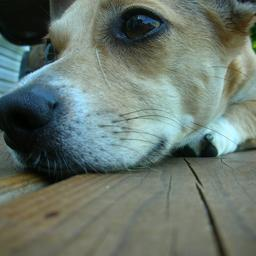
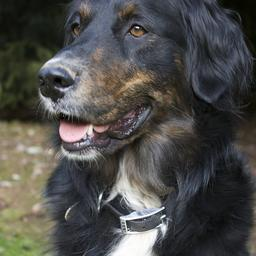
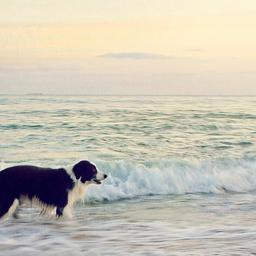
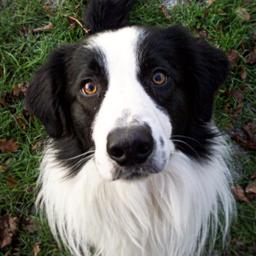
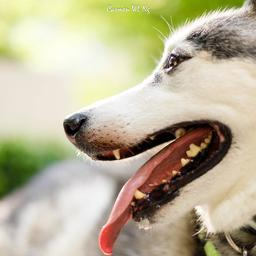
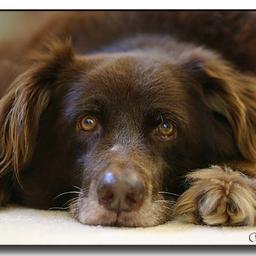
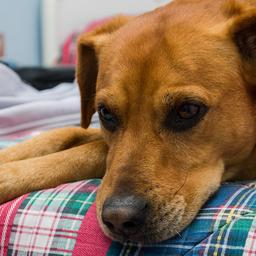
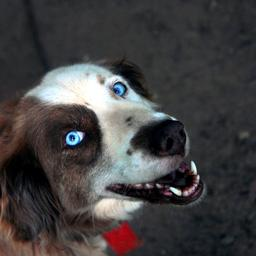
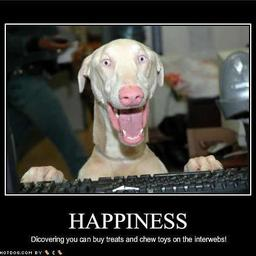
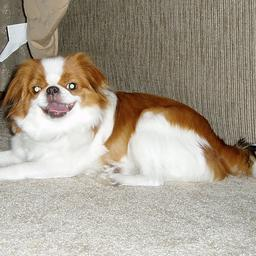
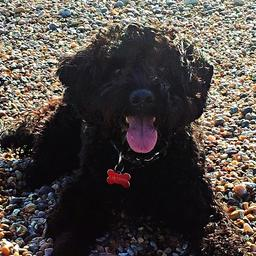
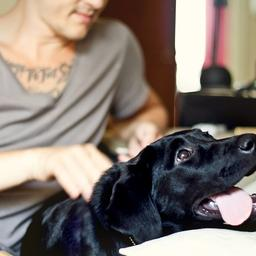
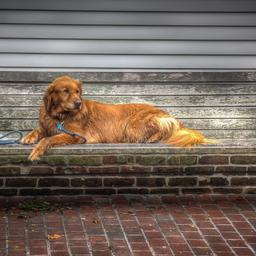
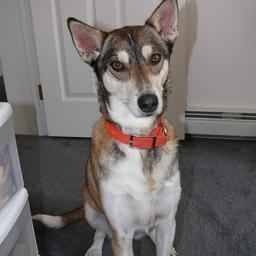
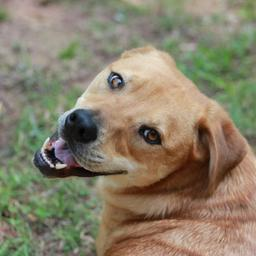
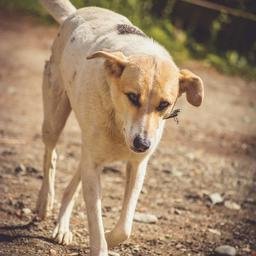
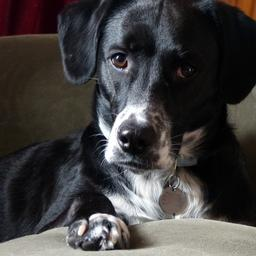
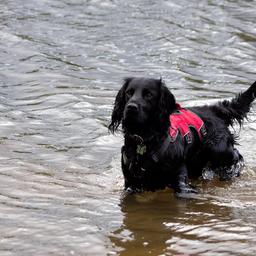
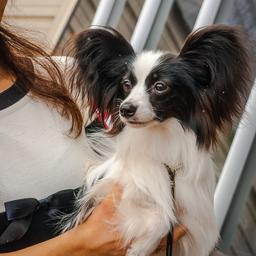
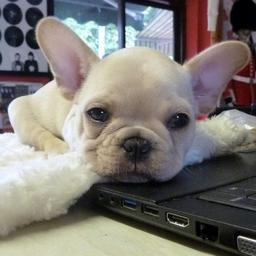
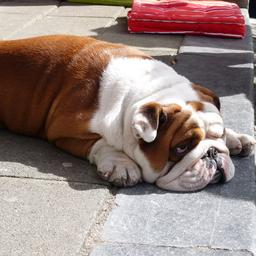
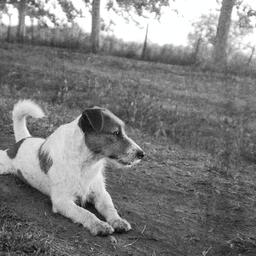
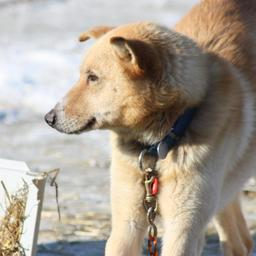
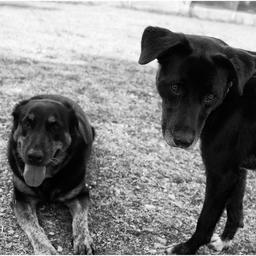
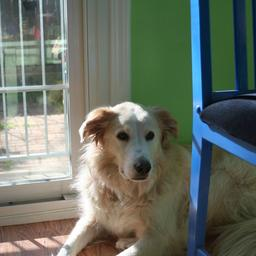
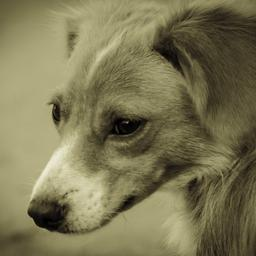
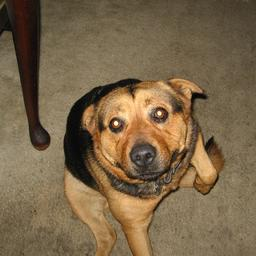
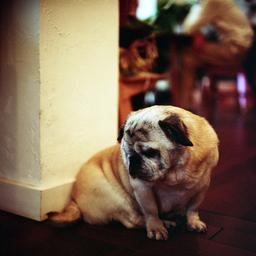
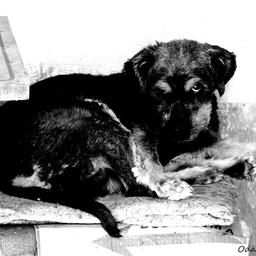
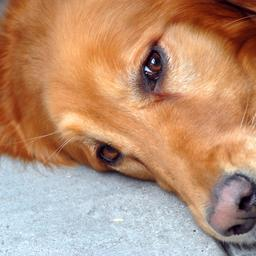
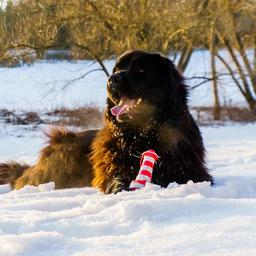
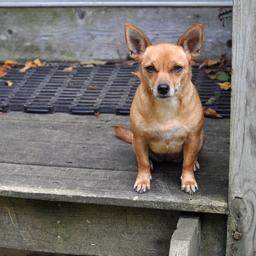
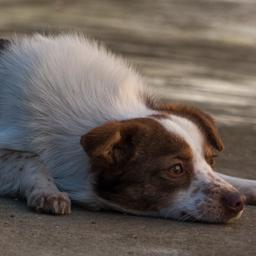
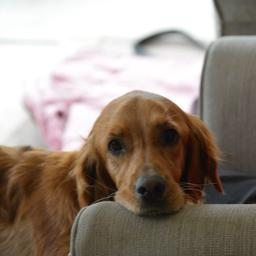
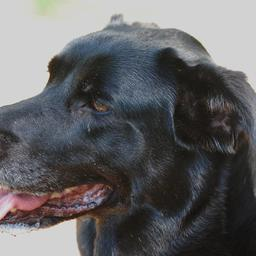
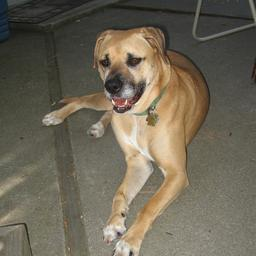
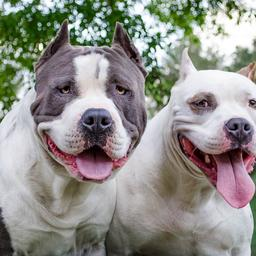
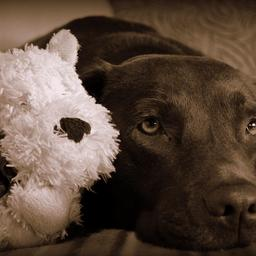
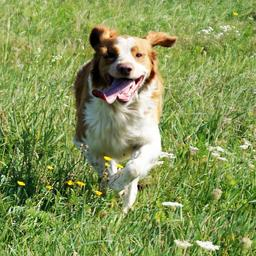
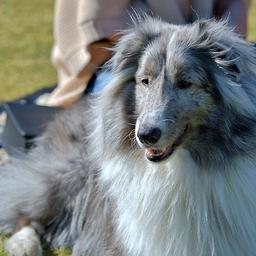
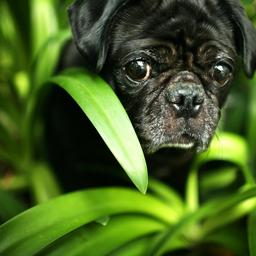
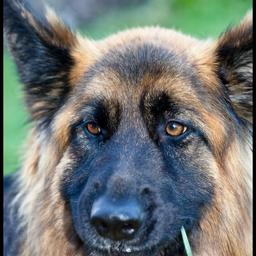
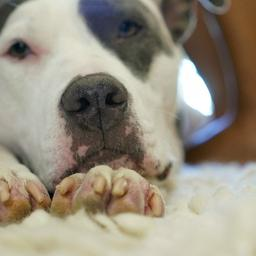
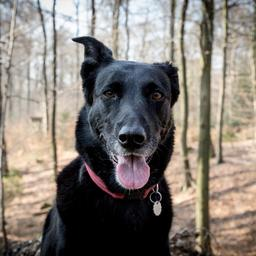
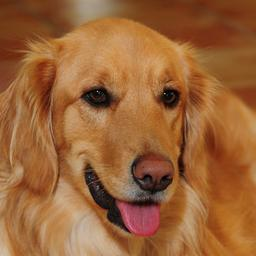
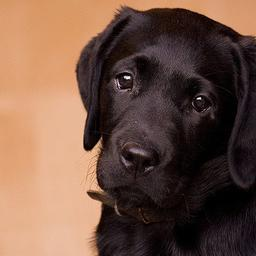
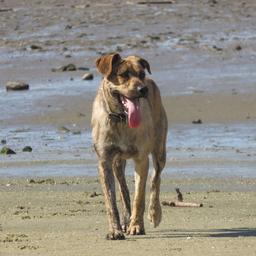
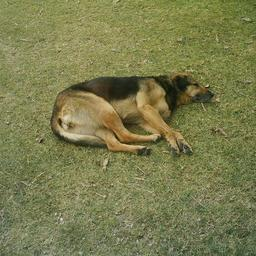
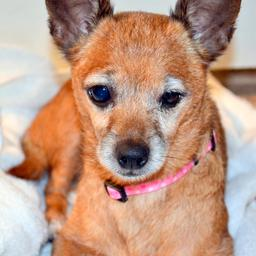
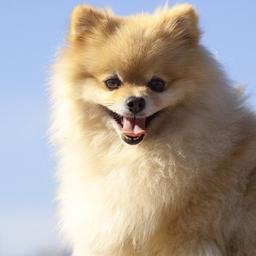

In [32]:
disp.style.format({'image': image_formatter})